# Model Kurulumu ve Veri Ön İşleme

In [1]:
!pip install transformers datasets scikit-learn --quiet
!pip install --upgrade transformers


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset

df = pd.read_excel("Final_Dataset.xlsx")
df[['content', 'category']].head()

,content,category
0,"Irak Petrol Bakanı Abdul Kerim Luaibi, Ankara...",Dunya
1,"Fransız güçleri, El Kaide'nin Kuzey Afrika'dak...",Dunya
2,"Wikileaks'in kaynağı, Amerika'da hakim karşısı...",Dunya
3,"İsrail'in, 6 Fetih Hareketi yöneticisini gözal...",Dunya
4,Myanmar'ın kuzeyinde bugün meydana gelen depre...,Dunya


Preprocessing

In [4]:
df = df.dropna()
#Kategoriler indekslenir ve sayı olarak kaydedilir.

label_map = {label: i for i, label in enumerate(df['category'].unique())}
df['label'] = df['category'].map(label_map)

# Veriyi Test ve Train olarak ayırırız
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Dataframi Datasete pandas ile dönüştürürüz
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

Model Oluşturma İşlemleri

In [5]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
#model çekimi
model_name = "dbmdz/bert-base-turkish-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# content tokenize hale getirilir.
def tokenize(example):
    return tokenizer(example["content"], truncation=True, padding="max_length", max_length=128)

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

# Modeli tanımlama
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_map))


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/38592 [00:00<?, ? examples/s]

Map:   0%|          | 0/9648 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
pip install wandb

# Model Configurations and Training

In [14]:
from transformers import TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='weighted')
    }

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
)
import os
os.environ["WANDB_DISABLED"] = "true" #huggingFace API Key gerekmemesi amacıyla disbled true işlemi yapıldı.

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [15]:
trainer.train()



Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.746700,0.705755,0.771041,0.759174
2,0.565200,0.686626,0.776430,0.770535
3,0.415700,0.824881,0.781405,0.777722
4,0.321100,1.041272,0.771870,0.770249
5,0.175500,1.343833,0.772595,0.771364


TrainOutput(global_step=24120, training_loss=0.4632051708291024, metrics={'train_runtime': 6138.6313, 'train_samples_per_second': 31.434, 'train_steps_per_second': 3.929, 'total_flos': 1.269338899562496e+16, 'train_loss': 0.4632051708291024, 'epoch': 5.0})

In [21]:
from sklearn.metrics import classification_report, confusion_matrix


In [17]:
# Test veri setinde tahmin
preds_output = trainer.predict(test_dataset)
y_pred = preds_output.predictions.argmax(axis=1)
y_true = preds_output.label_ids

In [18]:
class_names = df['category'].unique().tolist()
cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))

In [19]:
class_names

['Dunya',
 'Ekonomi',
 'Guncel',
 'Kultur',
 'Magazin',
 'Saglik',
 'Siyaset',
 'Spor',
 'Teknoloji',
 'Yasam']

In [20]:
print(cm)
print(classification_report(y_true, y_pred, target_names=class_names))

[[ 969   10   28    6  102    5   14    5   14   17]
 [  13  679   26    2  123    5   12    0   14    7]
 [  50   29  919   15  204   21   55   29   15   92]
 [   5    0    9  300   39    0    3    2    1    8]
 [ 134  148  213   35 1186   25   42   97   23   22]
 [   7    0   10    0   20  441    0    0    2    0]
 [  25    6   62    4   50    1  434    1    1    1]
 [   6    2    8    1   86    1    2 2040    0    2]
 [  10    6    5    0   19    1    2    0  369    2]
 [  20    2   73    1   33    0    0    2    1  117]]
              precision    recall  f1-score   support

       Dunya       0.78      0.83      0.80      1170
     Ekonomi       0.77      0.77      0.77       881
      Guncel       0.68      0.64      0.66      1429
      Kultur       0.82      0.82      0.82       367
     Magazin       0.64      0.62      0.63      1925
      Saglik       0.88      0.92      0.90       480
     Siyaset       0.77      0.74      0.76       585
        Spor       0.94      0.95   

In [21]:
trainer.evaluate()

{'eval_loss': 1.3438326120376587,
 'eval_accuracy': 0.7725953565505804,
 'eval_f1': 0.7713635277230483,
 'eval_runtime': 68.8804,
 'eval_samples_per_second': 140.069,
 'eval_steps_per_second': 17.509,
 'epoch': 5.0}

# Modeli Kaydetme

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

save_path = "/content/drive/MyDrive/bert_model_5Epoch"

# Modeli ve tokenizer'ı kaydet
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

('/content/drive/MyDrive/bert_model_5Epoch/tokenizer_config.json',
 '/content/drive/MyDrive/bert_model_5Epoch/special_tokens_map.json',
 '/content/drive/MyDrive/bert_model_5Epoch/vocab.txt',
 '/content/drive/MyDrive/bert_model_5Epoch/added_tokens.json',
 '/content/drive/MyDrive/bert_model_5Epoch/tokenizer.json')

# Eğitilmiş Modeli Yükleyip Tahminde Bulunma

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
from transformers import BertForSequenceClassification, BertTokenizer
from transformers import pipeline

model_path = "/content/drive/MyDrive/bert_model_final"

In [15]:
# Tokenizerı ve modeli yükle
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)

In [16]:
id2label = {
    0: 'Dunya',
    1: 'Ekonomi',
    2: 'Guncel',
    3: 'Kultur',
    4: 'Magazin',
    5: 'Saglik',
    6: 'Siyaset',
    7: 'Spor',
    8: 'Teknoloji',
    9: 'Yasam'
}

model.config.id2label = id2label
model.config.label2id = {v: k for k, v in id2label.items()}

text_classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

Device set to use cpu


Son satıra kadar olan kısım önemsizdir. Deneme amaçlı oluşturulmuştur.

In [10]:
from transformers import TrainingArguments, Trainer


In [17]:
trainer = Trainer(model=model)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [19]:
preds_output = trainer.predict(test_dataset)
y_pred = preds_output.predictions.argmax(axis=1)
y_true = preds_output.label_ids

In [22]:
class_names = df['category'].unique().tolist()
cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))
print(cm)
print(classification_report(y_true, y_pred, target_names=class_names))

[[ 991   13   39    3   70    4   16    5   20    9]
 [  17  703   29    0   99    7   11    0   14    1]
 [  48   23 1007   16  166   18   52   30   13   56]
 [   4    1   10  304   41    0    2    1    2    2]
 [ 159  159  217   36 1136   26   52   99   29   12]
 [  10    1   14    0   14  439    1    0    1    0]
 [  27    5   64    4   37    0  448    0    0    0]
 [   5    1   11    0   53    0    2 2072    3    1]
 [  12    8    6    0   16    1    2    0  369    0]
 [  22    2   82    3   26    0    0    3    1  110]]
              precision    recall  f1-score   support

       Dunya       0.77      0.85      0.80      1170
     Ekonomi       0.77      0.80      0.78       881
      Guncel       0.68      0.70      0.69      1429
      Kultur       0.83      0.83      0.83       367
     Magazin       0.69      0.59      0.63      1925
      Saglik       0.89      0.91      0.90       480
     Siyaset       0.76      0.77      0.77       585
        Spor       0.94      0.96   

In [23]:
from sklearn.metrics import accuracy_score, f1_score

print("Accuracy:", accuracy_score(y_true, y_pred))
print("F1 (macro):", f1_score(y_true, y_pred, average="macro"))

Accuracy: 0.7855514096185738
F1 (macro): 0.77113772906518


              precision    recall  f1-score   support

       Dunya       0.77      0.85      0.80      1170
     Ekonomi       0.77      0.80      0.78       881
      Guncel       0.68      0.70      0.69      1429
      Kultur       0.83      0.83      0.83       367
     Magazin       0.69      0.59      0.63      1925
      Saglik       0.89      0.91      0.90       480
     Siyaset       0.76      0.77      0.77       585
        Spor       0.94      0.96      0.95      2148
   Teknoloji       0.82      0.89      0.85       414
       Yasam       0.58      0.44      0.50       249

    accuracy                           0.79      9648
   macro avg       0.77      0.77      0.77      9648
weighted avg       0.78      0.79      0.78      9648



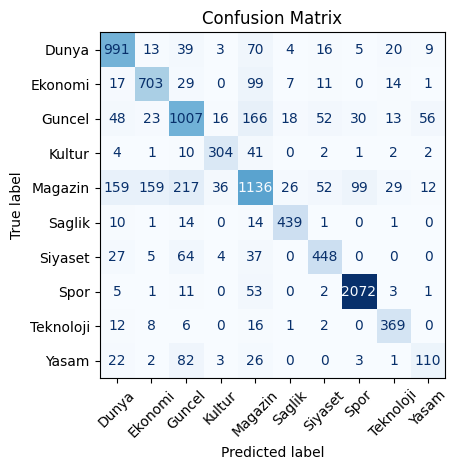

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
labels = [
    "Dunya", "Ekonomi", "Guncel", "Kultur", "Magazin",
    "Saglik", "Siyaset", "Spor", "Teknoloji", "Yasam"
]

# Confusion Matrix oluştur
cm = confusion_matrix(y_true, y_pred)

print(classification_report(y_true, y_pred, target_names=labels))

# Confusion Matrix’i çiz
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45, cmap="Blues", colorbar=False)
plt.title("Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()


In [26]:
result = text_classifier("Test Amaçlı geliştirilen uçan arabadan 200Watt güç tespit edildi.")
print(result)

[{'label': 'Teknoloji', 'score': 0.8523257374763489}]
